In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from render import render

In [2]:
def rotation(angle):
    return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

class Ray:
    def __init__(self, xpos, zpos, xdir, zdir):
        self.position = np.array([xpos, zpos])
        self.direction = np.array([xdir, zdir]) / (xdir**2 + zdir**2)**0.5
        self.velocity = 2**0.5
        self.num_reflections = 0

        self.position_history = [self.position]
        self.terminated = False

    def update(self, new_pos, new_dir):
        self.position = new_pos
        self.direction = new_dir
        self.position_history.append(new_pos.copy())


class Reflector:
    def __init__(self, xstart, zstart, xend, zend):
        self.start = np.array([xstart, zstart])
        self.end = np.array([xend, zend])

    def slope(self):
        return (self.end[1] - self.start[1]) / (self.end[0] - self.start[0])


class Domain:
    def __init__(self):
        self.x_start = 0
        self.x_end = 20
        self.z_start = 0
        self.z_end = 20

        self.max_reflections = 5

        self.ray_list = []
        self.reflector_list = []
        self.border_list = [Reflector(self.x_start, self.z_start, self.x_end, self.z_start),
                            Reflector(self.x_start, self.z_start, self.x_start, self.z_end),
                            Reflector(self.x_end, self.z_start, self.x_end, self.z_end),
                            Reflector(self.x_start, self.z_end, self.x_end, self.z_end)]

    def x_boundaries(self):
        return [self.x_start, self.x_end] 
    
    def z_boundaries(self):
        return [self.z_start, self.z_end] 

    def add_ray(self, ray):
        self.ray_list.append(ray)

    def add_reflector(self, reflector):
        self.reflector_list.append(reflector)

    def add_random_rays(self, num):
        for i in range(num):
            dice = (np.random.random(4))
            self.add_ray(Ray((dice[0]-0.5)*10+10, (dice[1]-0.5)*10+10, (dice[2]-0.5)*40, (dice[3]-1)*40))

    def trace_rays(self):
        for ray in self.ray_list:
            while not ray.terminated and ray.num_reflections < self.max_reflections:
                reflection_candidates = []
                for ref in self.reflector_list:
                    rhs = ref.start - ray.position
                    matrix = np.array([ray.direction*ray.velocity, ref.start - ref.end]).T
                    try: 
                        intersection_params = np.linalg.solve(matrix, rhs)
                        if 0 <= intersection_params[1] <= 1 and intersection_params[0] > 1e-5:
                            reflection_candidates.append((intersection_params, ref))
                    except: None
                
                if reflection_candidates:
                    best_reflector = min(reflection_candidates, key=lambda item: item[0][1])

                    reflection_events = True
                    ray.num_reflections += 1
                    intersection = ray.position + best_reflector[0][0] * ray.direction * ray.velocity
                    reflector_angle = np.arctan(best_reflector[1].slope())
                    reflected_direction = rotation(reflector_angle).T @ np.array([[1, 0], [0, -1]]) @ rotation(reflector_angle) @ ray.direction
                    ray.update(intersection, reflected_direction)
                else:
                    ray.terminated = True
                    for border in self.border_list:
                        rhs = border.start - ray.position
                        matrix = np.array([ray.direction*ray.velocity, border.start - border.end]).T
                        try: 
                            border_params = np.linalg.solve(matrix, rhs)
                            if 0 <= border_params[1] <= 1 and border_params[0] > 0:
                                border_intersection = ray.position + border_params[0] * ray.direction * ray.velocity
                                ray.update(border_intersection, np.array([0,0]))
                        except: None

    





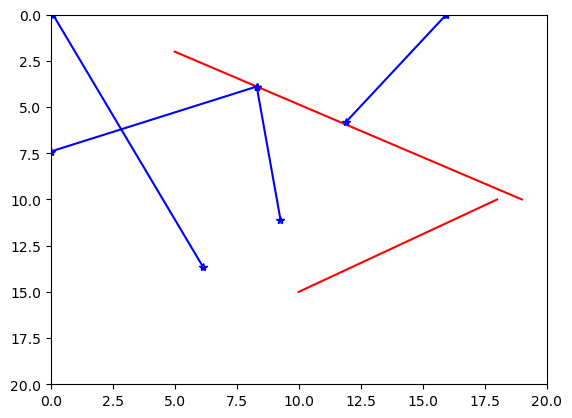

In [8]:
world = Domain()
world.add_reflector(Reflector(10,15,18,10))
world.add_reflector(Reflector(5,2,19,10))
world.add_random_rays(3)

world.trace_rays()
render(world.reflector_list, world.ray_list, world.x_boundaries(), world.z_boundaries())